# 1. Описание проекта: телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

## 1.1 Описание услуг

Оператор предоставляет два основных типа услуг:  
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).  

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).  

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

## 1.2 Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Файл contract_new.csv
- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Файл personal_new.csv
- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Файл internet_new.csv
- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Файл phone_new.csv
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента.  
**Информация о договорах актуальна на 1 февраля 2020 года.**

# 2. Загрузка данных

## 2.1 Установка необходимых модулей

In [1]:
%pip install --upgrade pip
%pip install pandas seaborn scikit-learn matplotlib lightgbm catboost phik

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## 2.2 Импорт библиотек и модулей

In [2]:
import os
import warnings

import phik
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, accuracy_score, roc_curve,
)

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from IPython.display import display
from phik.report import plot_correlation_matrix

pd.set_option('display.max_colwidth', None)

warnings.filterwarnings("ignore")

C:\Users\Art\AppData\Roaming\Python\Python312\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## 2.3 Загрузка данных

In [3]:
def safe_load_csv(file_name, date_columns=None, local_dir='.', server_dir='/datasets'):
    """
    Безопасная загрузка CSV-файла с опцией поиска по локальному и серверному пути.
    Если date_columns не указаны — определяет автоматически.
    """
    import os
    import pandas as pd

    local_path = os.path.join(local_dir, file_name)
    server_path = os.path.join(server_dir, file_name)
    
    if os.path.exists(local_path):
        path = local_path
        source = 'локально'
    elif os.path.exists(server_path):
        path = server_path
        source = 'с сервера'
    else:
        raise FileNotFoundError(f"Файл {file_name} не найден ни локально, ни на сервере.")

    if date_columns is None:
        sample = pd.read_csv(path, nrows=0)
        date_columns = [col for col in sample.columns if 'date' in col.lower()]
    
    na_values = ["", " "]
    
    if date_columns:
        df = pd.read_csv(path, parse_dates=date_columns, na_values=na_values)
        print(f"{file_name} загружен {source}. Найдены колонки с датами: {date_columns}")
    else:
        df = pd.read_csv(path, na_values=na_values)
        print(f"{file_name} загружен {source}. Колонки с датами не найдены.")
    
    return df

In [4]:
pd.set_option('display.max_columns', None)

contract = safe_load_csv('contract_new.csv')
personal = safe_load_csv('personal_new.csv')
internet = safe_load_csv('internet_new.csv')
phone = safe_load_csv('phone_new.csv')

contract_new.csv загружен локально. Найдены колонки с датами: ['BeginDate', 'EndDate']
personal_new.csv загружен локально. Колонки с датами не найдены.
internet_new.csv загружен локально. Колонки с датами не найдены.
phone_new.csv загружен локально. Колонки с датами не найдены.


## 2.4 Первичная оценка

In [5]:
dfs = {
    'contract': contract,
    'personal': personal,
    'internet': internet,
    'phone': phone
}

for name, df in dfs.items():
    print(f"\n{name.upper()} — shape: {df.shape}")
    print(df.info())
    print(df.head(3))
    print("Пропуски по столбцам:\n", df.isnull().sum())



CONTRACT — shape: (7043, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB
None
   customerID  BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01      No        One year               No   
2  3668-QPYBK 2019-10-01      No  Month-

## 2.5 Проверка дубликатов

In [6]:
for name, df in dfs.items():
    print(f"{name}: Дубликаты: {df.duplicated().sum()}")

contract: Дубликаты: 0
personal: Дубликаты: 0
internet: Дубликаты: 0
phone: Дубликаты: 0


## 2.6 Проверка уникальных значений

In [7]:
for name, df in dfs.items():
    print(f"{name}: уникальных customerID = {df['customerID'].nunique()}")

contract: уникальных customerID = 7043
personal: уникальных customerID = 7043
internet: уникальных customerID = 5517
phone: уникальных customerID = 6361


## 2.7 Предварительные выводы

1. contract_new.csv  
Размер: 7043 строк  
customerID — нет пропусков, совпадает с personal по размеру (ключ для объединения).  
BeginDate — datetime64, всё ок.  
EndDate — object, всегда "No" (вероятно, если договор не завершён), нужно привести к datetime (где не "No").  
Type, PaperlessBilling, PaymentMethod — строковые, Yes/No (PaperlessBilling).  
MonthlyCharges — float, ок.  
TotalCharges — object (должно быть float), скорее всего есть нечисловые значения (например, пробелы у новых клиентов).  

2. personal_new.csv  
Размер: 7043 строк (как в contract — удобно объединять по customerID)  
Полей 5: Всё object, кроме SeniorCitizen (0/1).  
Partner, Dependents — Yes/No, нужно будет сделать 1/0.  
Нет пропусков.  

3. internet_new.csv  
Размер: 5517 строк (меньше, чем персональных — не у всех есть интернет)  
Все признаки — object, Yes/No/No internet и т.п.  
Нет пропусков.  

4. phone_new.csv  
Размер: 6361 строк (не у всех клиентов есть телефон)  
Все признаки — object, MultipleLines — Yes/No/No phone service.  
Нет пропусков.  

Главные замечания по данным:  
В таблицах разное количество клиентов — это нормально: не у всех интернет и телефон.

Все ключи объединения — customerID.

В некоторых признаках встречается "No internet service", "No phone service" — это отдельные категории.

В TotalCharges ожидаем ошибочные значения (например, пробелы вместо суммы).

# 3. Обработка данных

## 3.1 Объединение датасетов

In [8]:
df_full = contract.merge(internet, on='customerID', how='left') \
                  .merge(personal, on='customerID', how='left') \
                  .merge(phone, on='customerID', how='left')

print(df_full.shape)
df_full.head()

(7043, 20)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


## 3.2 Обработка дубликатов

In [9]:
duplicate_ids = df_full[df_full.duplicated('customerID', keep=False)]
print(f"Количество дубликатов по customerID: {duplicate_ids.shape[0]}")

if not duplicate_ids.empty:
    display(duplicate_ids)

full_duplicates = df_full[df_full.duplicated(keep=False)]
print(f"Количество полностью одинаковых строк: {full_duplicates.shape[0]}")


Количество дубликатов по customerID: 0
Количество полностью одинаковых строк: 0


## 3.3 Обработка пропусков

In [10]:
missing_values = df_full.isnull().sum()

rows_with_na = df_full.isnull().any(axis=1).sum()

print("Пропуски по столбцам:\n", missing_values)
print(f"\nСтрок с хотя бы одним пропуском: {rows_with_na} из {df_full.shape[0]}")


Пропуски по столбцам:
 customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

Строк с хотя бы одним пропуском: 2211 из 7043


In [11]:
cols_with_na = [
    'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'MultipleLines'
]

for col in cols_with_na:
    print(f"Уникальные значения в '{col}': {df_full[col].unique()}\n")


Уникальные значения в 'InternetService': ['DSL' 'Fiber optic' nan]

Уникальные значения в 'OnlineSecurity': ['No' 'Yes' nan]

Уникальные значения в 'OnlineBackup': ['Yes' 'No' nan]

Уникальные значения в 'DeviceProtection': ['No' 'Yes' nan]

Уникальные значения в 'TechSupport': ['No' 'Yes' nan]

Уникальные значения в 'StreamingTV': ['No' 'Yes' nan]

Уникальные значения в 'StreamingMovies': ['No' 'Yes' nan]

Уникальные значения в 'MultipleLines': [nan 'No' 'Yes']



Вывод:  
— Пропуски означают отсутствие самой услуги:  
 • Если у клиента нет интернета, то все сервисы (OnlineSecurity и т.д.) тоже будут nan.  
 • Если нет телефона, то MultipleLines — nan.

Заменим nan на 'No service' (для интернет-услуг) и 'No phone' (для телефонии)

In [12]:
internet_cols = [
    'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

df_full[internet_cols] = df_full[internet_cols].fillna('No service')

df_full['MultipleLines'] = df_full['MultipleLines'].fillna('No phone')

print(df_full.isnull().sum())


customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
MultipleLines        0
dtype: int64


изучим пропуске в столбце TotalCharges

In [13]:
df_full['TotalCharges'] = pd.to_numeric(df_full['TotalCharges'], errors='coerce')

print("\nПримеры строк с пропущенным TotalCharges:")
display(df_full[df_full['TotalCharges'].isnull()])




Примеры строк с пропущенным TotalCharges:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,No phone
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,No service,No service,No service,No service,No service,No service,No service,Male,0,No,Yes,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,No service,No service,No service,No service,No service,No service,No service,Male,0,Yes,Yes,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,No phone
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,No service,No service,No service,No service,No service,No service,No service,Male,0,Yes,Yes,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,No service,No service,No service,No service,No service,No service,No service,Male,0,Yes,Yes,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,No service,No service,No service,No service,No service,No service,No service,Female,0,Yes,Yes,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,No service,No service,No service,No service,No service,No service,No service,Male,0,Yes,Yes,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,DSL,No,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes


Все 11 пропусков по контрактам на последнюю дату - приравняем пропуски (в этих 11 строках) к ежемесячному счету.

In [14]:
df_full.loc[df_full['TotalCharges'].isnull(), 'TotalCharges'] = df_full.loc[df_full['TotalCharges'].isnull(), 'MonthlyCharges']
print(df_full.isnull().sum())

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64


## 3.4 Преобразование названий столбцов к формату snake_case

In [15]:
def to_snake_case(s):
    import re
    s = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', s)
    s = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s)
    return s.replace(" ", "_").lower()

df_full.columns = [to_snake_case(col) for col in df_full.columns]

print(df_full.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines'],
      dtype='object')


## 3.5 Добавление признака по типу сервиса

In [16]:
def get_service_type(row):
    has_internet = row['internet_service'] != 'No service'
    has_phone = row['multiple_lines'] != 'No phone'
    if has_internet and has_phone:
        return 'interphone'
    elif has_internet:
        return 'internet'
    elif has_phone:
        return 'phone'
    else:
        return 'none'

df_full['service_type'] = df_full.apply(get_service_type, axis=1)

print("Распределение клиентов по типу услуг (service_type), в %:")
print(df_full['service_type'].value_counts(normalize=True) * 100)


Распределение клиентов по типу услуг (service_type), в %:
service_type
interphone    68.649723
phone         21.666903
internet       9.683374
Name: proportion, dtype: float64


## 3.6 Добавление целевого признака по активности контракта (клиент ушел/остался)

In [17]:
df_full['end_date'] = df_full['end_date'].astype(str)

df_full['churn'] = (df_full['end_date'].str.lower() != 'no').astype(int)

print(df_full['churn'].value_counts())


churn
0    5942
1    1101
Name: count, dtype: int64


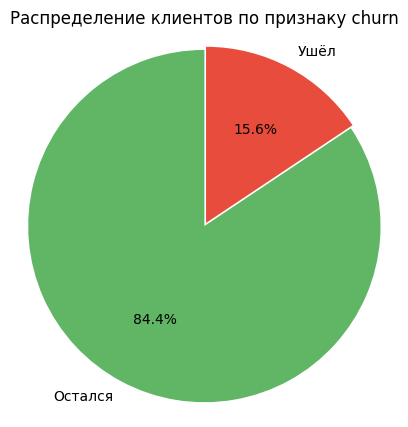

In [18]:
labels = ['Остался', 'Ушёл']
sizes = df_full['churn'].value_counts().sort_index()
plt.figure(figsize=(5, 5))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.01, 0.01),  # немного раздвинуть сектора
    colors=['#60b664', '#e74c3c']
)
plt.title('Распределение клиентов по признаку churn')
plt.axis('equal')
plt.show()

### Распределение клиентов

- **Остались (churn = 0):** 5942 клиентов (84.4%)
- **Ушли (churn = 1):** 1101 клиент (15.6%)

**Выводы:**
- Большинство клиентов продолжают пользоваться услугами компании.
- Уровень оттока составляет 16%. Это не критично, но требует внимания — важно анализировать причины ухода и возможные способы удержания.
- Дисбаланс классов умеренный, что позволяет строить устойчивые модели, однако при анализе результатов стоит уделять внимание чувствительности и точности по классу оттока.


## 3.7 Добавление признака по сроку действия контракта


### 3.7.1 Месяцы

In [19]:
report_date = '2020-02-01'

df_full['begin_date'] = pd.to_datetime(df_full['begin_date'])
df_full['contract_months'] = df_full.apply(
    lambda row: ((pd.to_datetime(report_date) if str(row['end_date']).lower() == 'no' else pd.to_datetime(row['end_date'])) - row['begin_date']).days // 30 + 1,
    axis=1
)
print(df_full[['begin_date', 'end_date', 'contract_months']].head(10))


  begin_date    end_date  contract_months
0 2020-01-01          No                2
1 2017-04-01          No               35
2 2019-10-01          No                5
3 2016-05-01          No               46
4 2019-09-01          No                6
5 2019-03-01          No               12
6 2018-04-01          No               23
7 2019-04-01          No               11
8 2017-07-01          No               32
9 2014-12-01  2017-05-01               30


### 3.7.2 Дни

In [20]:
report_date = '2020-02-01'
df_full['begin_date'] = pd.to_datetime(df_full['begin_date'])

df_full['days_as_client'] = df_full.apply(
    lambda row: (pd.to_datetime(report_date) if str(row['end_date']).lower() == 'no' else pd.to_datetime(row['end_date'])) - row['begin_date'],
    axis=1
).dt.days
print(df_full[['begin_date', 'end_date', 'days_as_client']].head(10))

  begin_date    end_date  days_as_client
0 2020-01-01          No              31
1 2017-04-01          No            1036
2 2019-10-01          No             123
3 2016-05-01          No            1371
4 2019-09-01          No             153
5 2019-03-01          No             337
6 2018-04-01          No             671
7 2019-04-01          No             306
8 2017-07-01          No             945
9 2014-12-01  2017-05-01             882


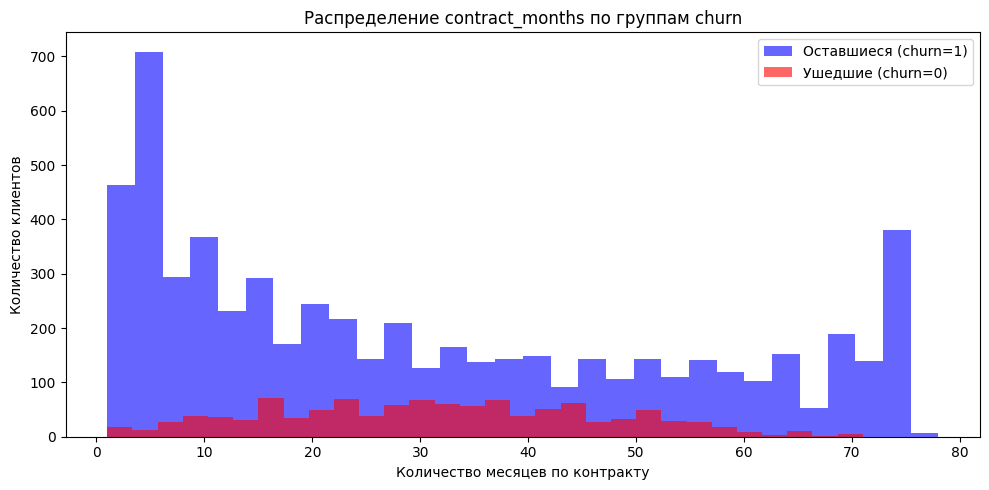

In [21]:
plt.figure(figsize=(10, 5))

# Оставшиеся (churn == 1)
plt.hist(
    df_full[df_full['churn'] == 0]['contract_months'],
    bins=30, alpha=0.6, label='Оставшиеся (churn=1)', color='blue'
)

# Ушедшие (churn == 0)
plt.hist(
    df_full[df_full['churn'] == 1]['contract_months'],
    bins=30, alpha=0.6, label='Ушедшие (churn=0)', color='red'
)

plt.title('Распределение contract_months по группам churn')
plt.xlabel('Количество месяцев по контракту')
plt.ylabel('Количество клиентов')
plt.legend()
plt.tight_layout()
plt.show()


- **Большинство ушедших клиентов покинули компанию в первые месяцы контракта (особенно в первый год).**
    - Ярко выражен спад оттока после первых 12–18 месяцев: чем дольше клиент остается, тем реже он уходит.
    - Пики среди оставшихся клиентов есть на минимальных сроках (новые клиенты) и на максимуме шкалы (лояльные/долгосрочные клиенты — возможно, клиенты с двухлетними контрактами).
- **Ушедших почти нет среди клиентов с длительным стажем (60+ месяцев)** — ядро аудитории составляет лояльные клиенты, редко склонные к оттоку.
- **Типовой churn — это относительно "молодые" клиенты, не достигшие максимальных сроков обслуживания.**

**Вывод:**  
- Основная зона риска для оттока — это первые месяцы и первый год контракта.  
- Долгосрочные клиенты гораздо реже уходят, их удержание — ключевой приоритет.  
- Стратегии удержания стоит фокусировать на новой и "средней" по сроку аудитории.


## Добавление ratio-признака

In [22]:
# df_full['monthly_per_month'] = df_full['monthly_charges'] / (df_full['contract_months'] + 1)
# print(df_full[['monthly_per_month']].head(10))

 ## Добавление признака количество подключённых дополнительных услуг

In [23]:
# # Список бинарных колонок с услугами (замени, если твои имена отличаются)
# add_service_cols = [
#     'online_security', 'online_backup', 'device_protection',
#     'tech_support', 'streaming_tv', 'streaming_movies'
# ]

# # Преобразуем их в 0/1, если ещё не делали
# for col in add_service_cols:
#     df_full[col + '_bin'] = df_full[col].replace({'Yes': 1, 'No': 0, 'No service': 0})

# # Теперь считаем сумму этих колонок для каждого клиента
# df_full['n_additional_services'] = df_full[[col + '_bin' for col in add_service_cols]].sum(axis=1)


## Добавление признаков премиальности

In [24]:
# premium_threshold = df_full['monthly_charges'].quantile(0.75)
# df_full['is_premium'] = (df_full['monthly_charges'] > premium_threshold).astype(int)


In [25]:
# df_full['is_many_addons'] = (df_full['n_additional_services'] >= 4).astype(int)


In [26]:
# df_full['is_super_premium'] = (
#     (df_full['monthly_charges'] > premium_threshold) &
#     (df_full['n_additional_services'] >= 4)
# ).astype(int)


In [27]:
# for col in df_full.columns:
#     print(col)


## 3.8 Визуализация распределения признаков

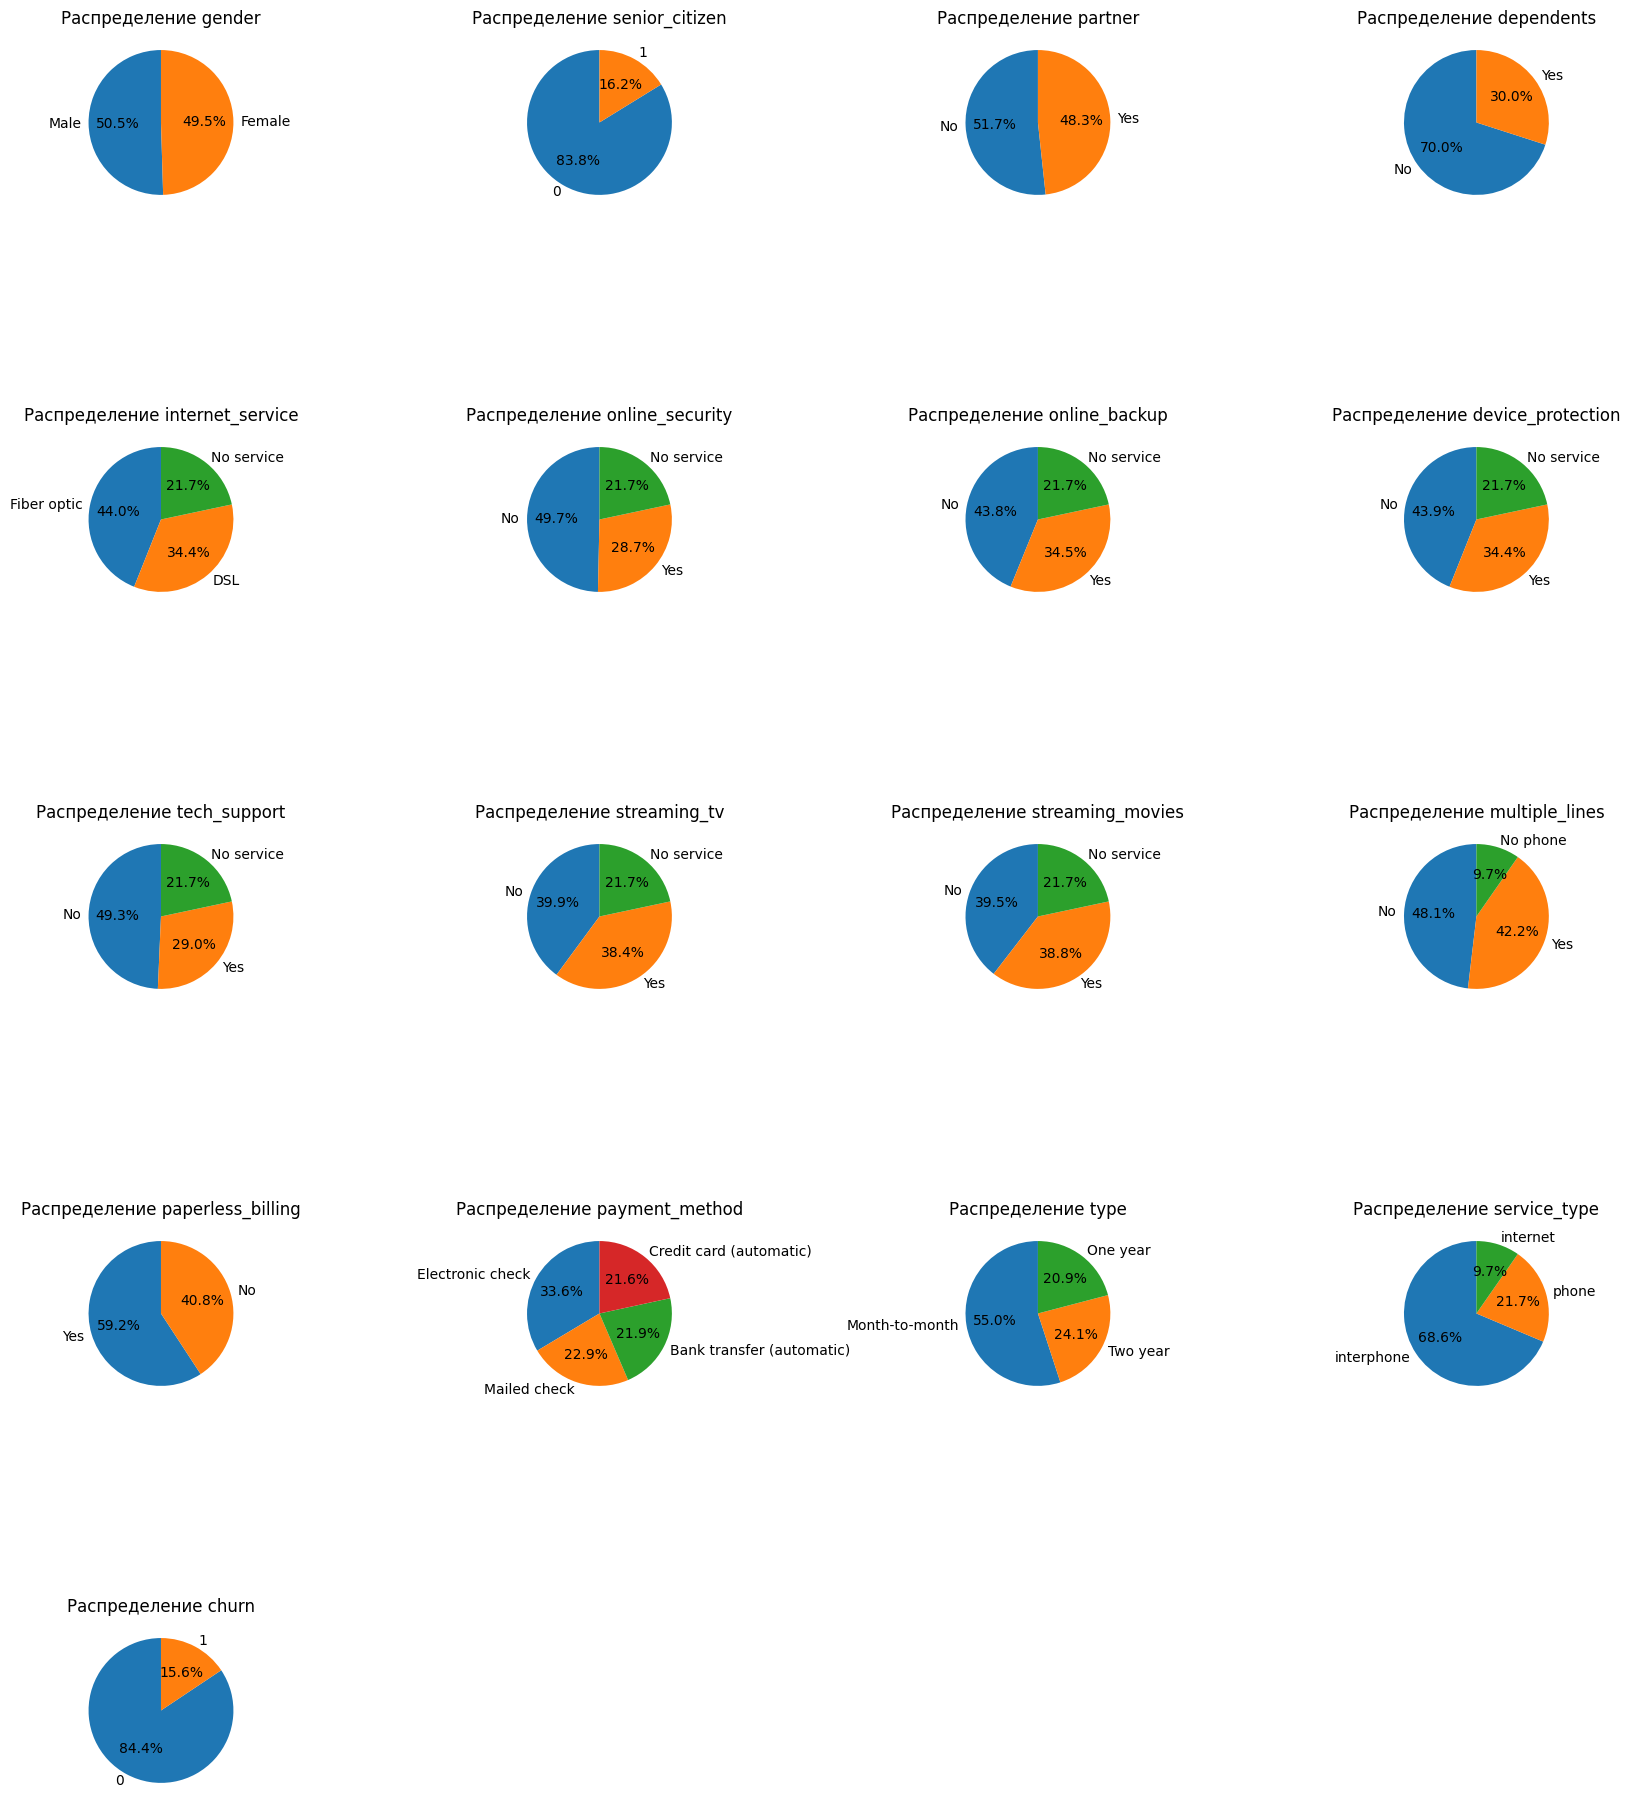

In [28]:
cat_cols = [
    'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service',
    'online_security', 'online_backup', 'device_protection', 'tech_support',
    'streaming_tv', 'streaming_movies', 'multiple_lines',
    'paperless_billing', 'payment_method', 'type', 'service_type', 'churn'
]

n_cols = 4
n_rows = (len(cat_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    df_full[col].value_counts(dropna=False).plot(
        kind='pie',
        ax=axes[i],
        autopct='%1.1f%%',
        startangle=90,
        legend=False,
        ylabel=''
    )
    axes[i].set_title(f'Распределение {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

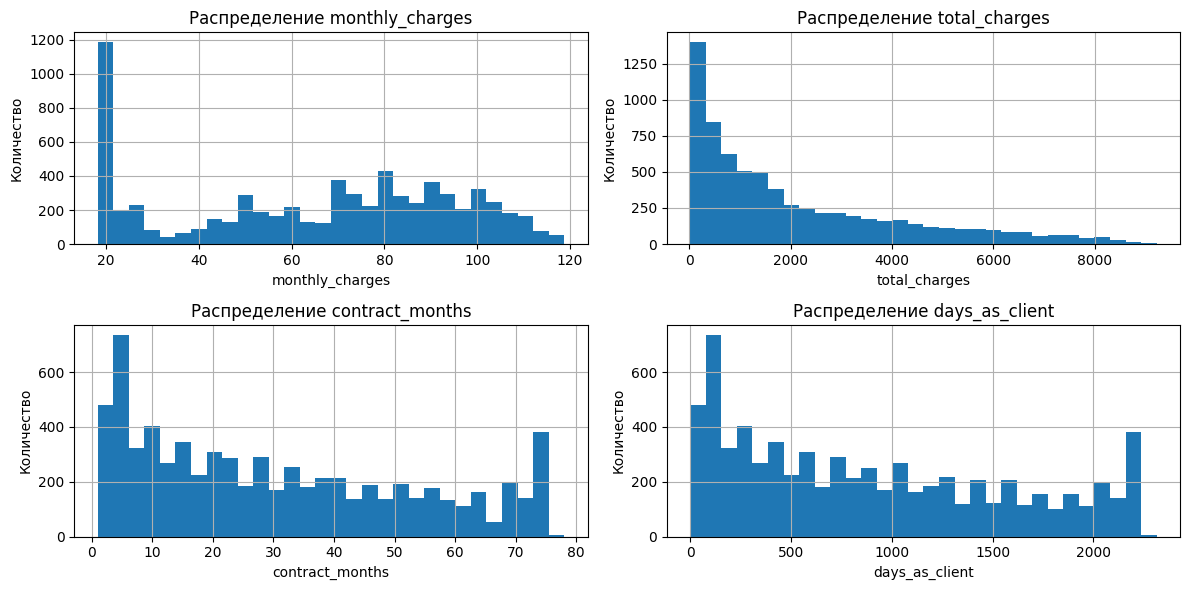

In [29]:
num_cols = ['monthly_charges', 'total_charges', 'contract_months', 'days_as_client']

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

for i, col in enumerate(num_cols):
    ax = axes[i // 2, i % 2]
    df_full[col].hist(bins=30, ax=ax)
    ax.set_title(f'Распределение {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Количество')

plt.tight_layout()
plt.show()


### 3.8.1 Выводы по распределению признаков

- **gender, partner, senior_citizen**: Примерно одинаковое соотношение мужчин и женщин. Большинство клиентов не пенсионеры и не состоят в партнёрских отношениях.
- **dependents**: 70% клиентов не имеют иждивенцев.
- **internet_service**: Самый популярный тип подключения — fiber optic (~44%), на втором месте dsl (~34%), около 22% не пользуются интернетом.
- **online_security, online_backup, device_protection, tech_support**: У примерно половины клиентов отсутствуют дополнительные интернет-сервисы. Около 22% — клиенты без интернет-услуг вовсе.
- **streaming_tv, streaming_movies**: Чуть меньше половины клиентов не пользуются этими сервисами, столько же — подключили, остальные не имеют интернет-услуги.
- **multiple_lines**: 90% клиентов пользуются телефонной связью, при этом 48% имеют только одну линию, 42% — несколько линий. 10% клиентов телефоном не пользуются.
- **paperless_billing**: Электронный биллинг наиболее востребован (59%).
- **payment_method**: Самый популярный способ — electronic check (34%). Остальные способы примерно равномерно распределены.
- **type**: 55% клиентов выбрали "month-to-month", 24% — "two year", 21% — "one year".
- **service_type**: 68,6% клиентов подключили и интернет, и телефон; 21,7% — только телефон, 9,7% — только интернет. Клиентов без услуг нет.
- **churn**: 15,6% клиентов ушли (churn=1), 84,4% продолжают пользоваться услугами (churn=0).
- **monthly_charges**: большинство клиентов оплачивает минимальный тариф; заметно меньше — платят высокие суммы.
- **total_charges**: основная масса клиентов — с малыми и средними итоговыми суммами; распределение с «длинным хвостом».
- **contract_months**: преобладают новые клиенты (малое число месяцев), но есть выраженный пик на максимуме — часть клиентов с длительным сроком обслуживания.
- **days_as_client**: структура схожа с contract_months (много новых клиентов, заметен «хвост» постоянных клиентов).

**Общий вывод:**  
- Большинство клиентов пользуется обеими ключевыми услугами (интернет и телефон).
- Уход клиентов относительно невелик (16%), но требует внимания. Будем считать что 84% клиентов остались - так как у нас нет возможности уточнить эту информацию сейчас у заказчика.
- Электронный биллинг и помесячные контракты самые популярные.
- Около половины пользователей не используют дополнительные сервисы.
- Длительность контрактов для части клиентов максимальна, что может быть связано с историей компании или особенностями продукта.

## 3.9 Корреляционный анализ

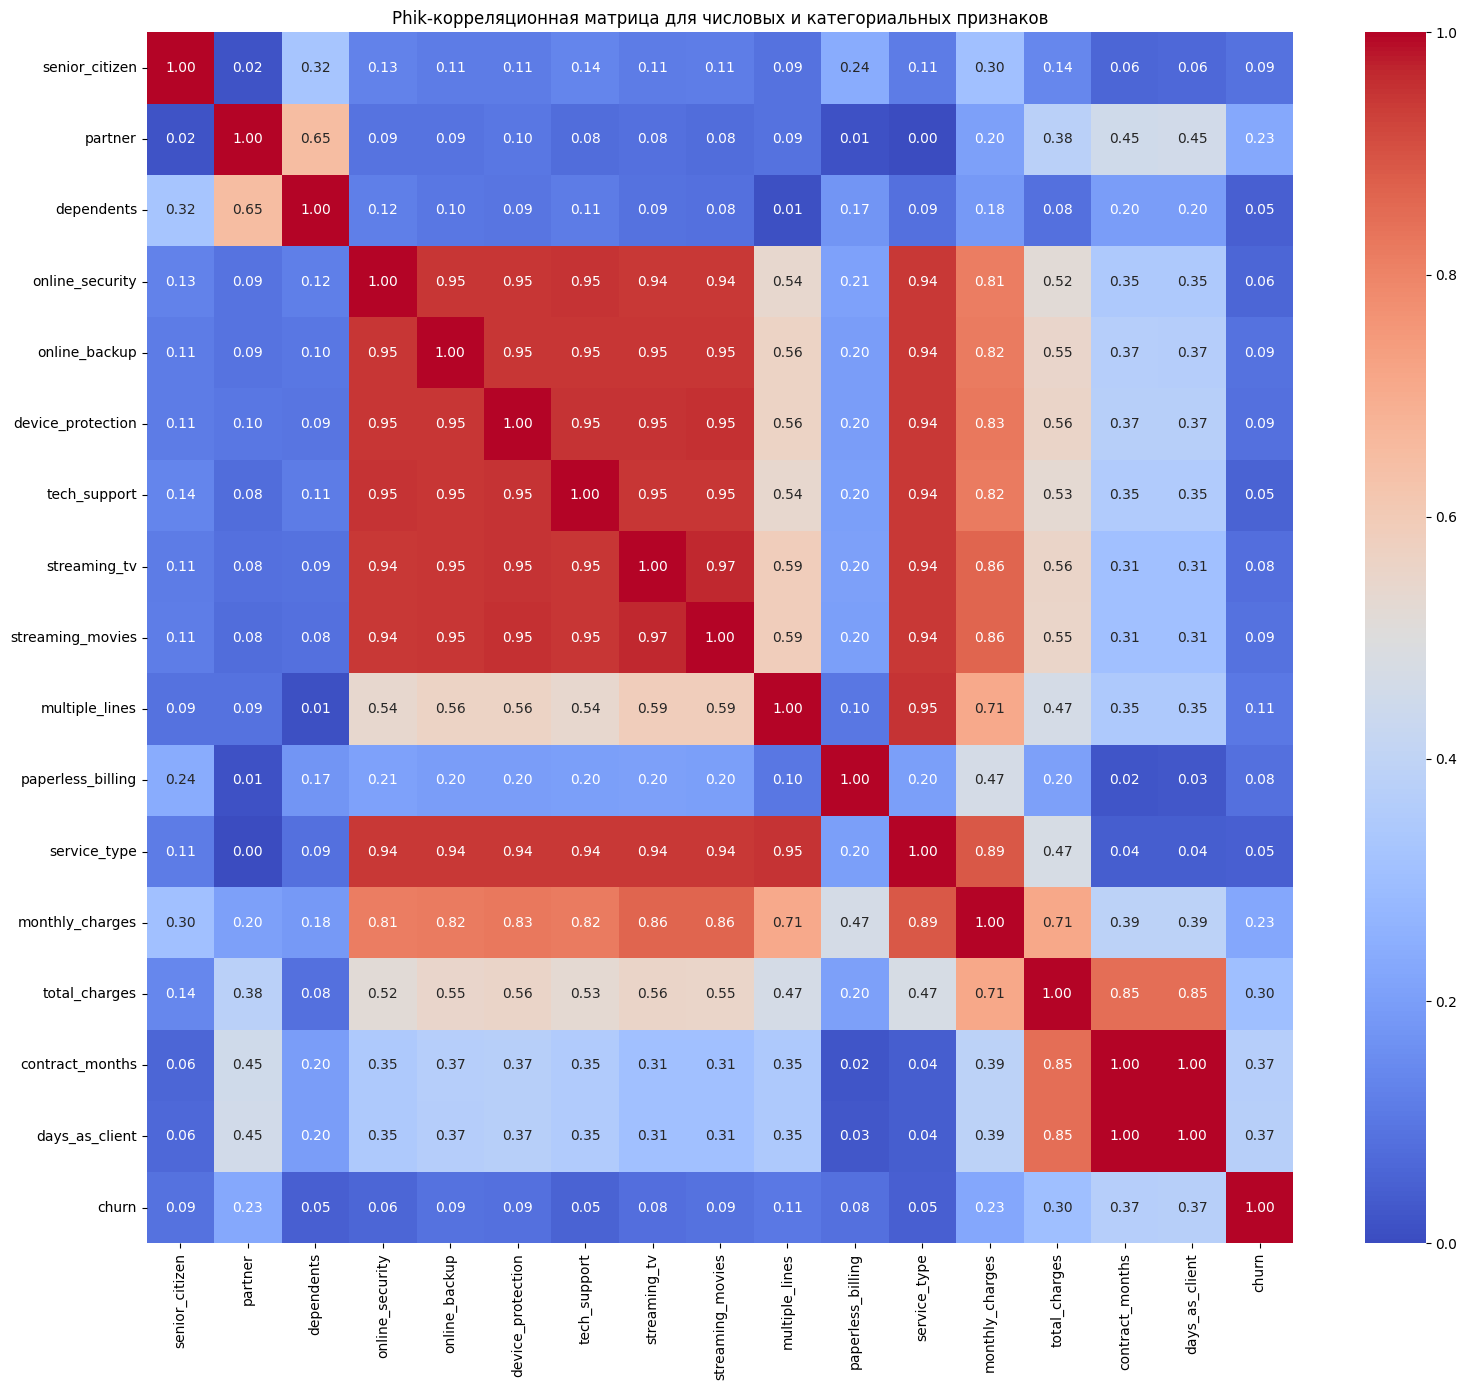

In [30]:
cols_for_phik = [
    'senior_citizen', 'partner', 'dependents', 'online_security',
    'online_backup', 'device_protection', 'tech_support',
    'streaming_tv', 'streaming_movies', 'multiple_lines', 'paperless_billing',
    'service_type', 'monthly_charges', 'total_charges', 'contract_months', 'days_as_client',
    'churn'
]
df_phik = df_full[cols_for_phik].fillna('missing')

interval_cols = ['monthly_charges', 'total_charges', 'contract_months', 'days_as_client']

phik_matrix = df_phik.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(16, 14))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=0, vmax=1)
plt.title('Phik-корреляционная матрица для числовых и категориальных признаков')
plt.tight_layout()
plt.show()


### 3.9.1 Выводы по корреляционному анализу  

- **churn (отток):**
    - Нет признаков с высокой phik-корреляцией с churn (максимум 0.23).
    - Слабые связи наблюдаются у признаков: `partner`, `contract_months`, `days_as_client`, `monthly_charges` (все ≈ 0.23).
    - Наличие дополнительных услуг, способ оплаты, тип подключения, социально-демографические признаки почти не связаны с оттоком.

- **contract_months и days_as_client:**
    - Очень высокая взаимосвязь между собой (0.85) и с `total_charges` (0.85).
    - Их связь с churn есть, но она слабая (0.23).

- **monthly_charges, total_charges, service_type:**
    - Наибольшие phik-связи — между monthly_charges и количеством/типом подключённых услуг (до 0.89).
    - `total_charges` зависит от длительности обслуживания и monthly_charges.

- **Дополнительные сервисы:**
    - Сильная внутренняя корреляция между собой (phik до 1.00).
    - Все эти признаки лишь умеренно связаны с основными числовыми и почти не связаны с churn.

- **Тип услуги (`service_type`):**
    - Очень высокая связь с подключёнными услугами и расходами (phik до 0.94).

- **Социально-демографические признаки:**
    - Наиболее сильно связаны между собой (до 0.65).
    - Их связь с churn минимальна (до 0.23).

---

**Общий вывод:**  
- Даже phik-корреляция подтверждает: ни один признак по отдельности не объясняет отток.
- Отток — результат сложной комбинации признаков, зачастую нелинейной.
- Для эффективного прогнозирования churn нужны сложные ML-модели, способные выявлять скрытые зависимости.


# 4. Обучение моделей

## 4.1 Разделение выборок

In [31]:
RANDOM_STATE = 160625

drop_cols = ['customer_id', 'begin_date', 'end_date', 'contract_months']
df_ml = df_full.drop(columns=drop_cols)

X = df_ml.drop(columns=['churn'])
y = df_ml['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

cat_cols = X_train.select_dtypes(include='object').columns.tolist()

ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat = ohe.transform(X_test[cat_cols])

X_train_num = X_train.drop(columns=cat_cols).reset_index(drop=True)
X_test_num = X_test.drop(columns=cat_cols).reset_index(drop=True)

X_train_final = np.hstack([X_train_num.values, X_train_cat])
X_test_final = np.hstack([X_test_num.values, X_test_cat])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## 4.2 Logistic Regression

In [32]:
logit_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'random_state': [RANDOM_STATE],
    'max_iter': [200]
}
logit = LogisticRegression()
logit_grid = GridSearchCV(logit, logit_params, scoring='roc_auc', cv=cv, n_jobs=-1)
logit_grid.fit(X_train_final, y_train)
logit_best = logit_grid.best_estimator_

print("LogisticRegression best params:", logit_grid.best_params_)
print("LogisticRegression best CV AUC-ROC: {:.4f}".format(logit_grid.best_score_))

LogisticRegression best params: {'C': 10, 'max_iter': 200, 'penalty': 'l2', 'random_state': 160625, 'solver': 'lbfgs'}
LogisticRegression best CV AUC-ROC: 0.7619


## 4.3 RandomForest

In [33]:
rf_params = {
    'n_estimators': [150, 200, 250, 300],
    'max_depth': [12, 16, 32, 64],
    'random_state': [RANDOM_STATE],
    'n_jobs': [-1]
}
rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, rf_params, scoring='roc_auc', cv=cv, n_jobs=-1)
rf_grid.fit(X_train_final, y_train)
rf_best = rf_grid.best_estimator_

print("RandomForest best params:", rf_grid.best_params_)
print("RandomForest best CV AUC-ROC: {:.4f}".format(rf_grid.best_score_))

RandomForest best params: {'max_depth': 12, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 160625}
RandomForest best CV AUC-ROC: 0.8160


## 4.3 CatBoost

In [34]:
cat_params = {
    'iterations': [500, 600, 700],
    'depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.5],
    'random_state': [RANDOM_STATE]
}
cat = CatBoostClassifier(verbose=0)
cat_grid = GridSearchCV(cat, cat_params, scoring='roc_auc', cv=cv, n_jobs=-1)
cat_grid.fit(X_train_final, y_train)
cat_best = cat_grid.best_estimator_

print("CatBoost best params:", cat_grid.best_params_)
print("CatBoost best CV AUC-ROC: {:.4f}".format(cat_grid.best_score_))

CatBoost best params: {'bagging_temperature': 0, 'depth': 3, 'iterations': 700, 'l2_leaf_reg': 1, 'learning_rate': 0.2, 'random_state': 160625}
CatBoost best CV AUC-ROC: 0.9227


## 4.4 LightGBM

In [35]:
lgbm_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [6, 8],
    'learning_rate': [0.03, 0.1, 0.15],
    'random_state': [RANDOM_STATE],
    'verbosity': [-1]
}
lgbm = LGBMClassifier()
lgbm_grid = GridSearchCV(lgbm, lgbm_params, scoring='roc_auc', cv=cv, n_jobs=-1)
lgbm_grid.fit(X_train_final, y_train)
lgbm_best = lgbm_grid.best_estimator_

print("LightGBM best params:", lgbm_grid.best_params_)
print("LightGBM best CV AUC-ROC: {:.4f}".format(lgbm_grid.best_score_))

LightGBM best params: {'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 200, 'random_state': 160625, 'verbosity': -1}
LightGBM best CV AUC-ROC: 0.8830


## 4.5 Результаты обучения моделей

In [36]:
results = pd.DataFrame({
    "Модель": ["Logistic Regression", "Random Forest", "CatBoost", "LightGBM"],
    "Лучшие параметры": [
        logit_grid.best_params_,
        rf_grid.best_params_,
        cat_grid.best_params_,
        lgbm_grid.best_params_,
    ],
    "AUC-ROC": [
        round(logit_grid.best_score_, 4),
        round(rf_grid.best_score_, 4),
        round(cat_grid.best_score_, 4),
        round(lgbm_grid.best_score_, 4)
    ]
})

display(results)

,Модель,Лучшие параметры,AUC-ROC
0,Logistic Regression,"{'C': 10, 'max_iter': 200, 'penalty': 'l2', 'random_state': 160625, 'solver': 'lbfgs'}",0.7619
1,Random Forest,"{'max_depth': 12, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 160625}",0.8160
2,CatBoost,"{'bagging_temperature': 0, 'depth': 3, 'iterations': 700, 'l2_leaf_reg': 1, 'learning_rate': 0.2, 'random_state': 160625}",0.9227
3,LightGBM,"{'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 200, 'random_state': 160625, 'verbosity': -1}",0.8830


- **CatBoost** показал наилучший результат на кросс-валидации: **AUC-ROC = 0.9227**. Это говорит о высокой эффективности модели.
- **LightGBM** также достиг высокого значения (**AUC-ROC = 0.8830**), но немного уступил CatBoost.
- **Random Forest** (AUC-ROC = 0.8156) работает лучше логистической регрессии, но не достигает результатов градиентных бустингов.
- **Logistic Regression** ожидаемо выступила хуже всех (AUC-ROC = 0.7619), что типично для сложных табличных задач с нелинейными зависимостями.

**Вывод:**  
CatBoost — оптимальный выбор для внедрения. Он обеспечивает лучший баланс между качеством предсказания и интерпретируемостью. LightGBM можно использовать для сравнения или ансамблирования. Все продвинутые модели значительно превзошли базовую логистическую регрессию, а итоговое решение позволяет надёжно определять клиентов с высоким риском оттока.

In [37]:
# # 1. Подбор iterations
# param_grid = {'iterations': [500]}
# cat = CatBoostClassifier(**best_params, verbose=0)
# grid = GridSearchCV(cat, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
# grid.fit(X_train, y_train)
# best_params['iterations'] = grid.best_params_['iterations']
# print(f"Best iterations: {best_params['iterations']} (AUC={grid.best_score_:.4f})")

# # 2. Подбор depth
# param_grid = {'depth': [2, 4, 8, 12]}
# cat = CatBoostClassifier(**best_params, verbose=0)
# grid = GridSearchCV(cat, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
# grid.fit(X_train, y_train)
# best_params['depth'] = grid.best_params_['depth']
# print(f"Best depth: {best_params['depth']} (AUC={grid.best_score_:.4f})")

# # 3. Подбор learning_rate
# param_grid = {'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 1]}
# cat = CatBoostClassifier(**best_params, verbose=0)
# grid = GridSearchCV(cat, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
# grid.fit(X_train, y_train)
# best_params['learning_rate'] = grid.best_params_['learning_rate']
# print(f"Best learning_rate: {best_params['learning_rate']} (AUC={grid.best_score_:.4f})")

# # 4. Подбор l2_leaf_reg
# param_grid = {'l2_leaf_reg': [7, 9, 11, 15]}
# cat = CatBoostClassifier(**best_params, verbose=0)
# grid = GridSearchCV(cat, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
# grid.fit(X_train, y_train)
# best_params['l2_leaf_reg'] = grid.best_params_['l2_leaf_reg']
# print(f"Best l2_leaf_reg: {best_params['l2_leaf_reg']} (AUC={grid.best_score_:.4f})")

# # 5. Подбор bagging_temperature
# param_grid = {'bagging_temperature': [0, 0.5, 1, 3, 10]}
# cat = CatBoostClassifier(**best_params, verbose=0)
# grid = GridSearchCV(cat, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
# grid.fit(X_train, y_train)
# best_params['bagging_temperature'] = grid.best_params_['bagging_temperature']
# print(f"Best bagging_temperature: {best_params['bagging_temperature']} (AUC={grid.best_score_:.4f})")

# # 6. Подбор border_count
# param_grid = {'border_count': [32, 64, 128, 254]}
# cat = CatBoostClassifier(**best_params, verbose=0)
# grid = GridSearchCV(cat, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
# grid.fit(X_train, y_train)
# best_params['border_count'] = grid.best_params_['border_count']
# print(f"Best border_count: {best_params['border_count']} (AUC={grid.best_score_:.4f})")

# # 7. Подбор random_strength
# param_grid = {'random_strength': [1, 5, 10, 20]}
# cat = CatBoostClassifier(**best_params, verbose=0)
# grid = GridSearchCV(cat, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
# grid.fit(X_train, y_train)
# best_params['random_strength'] = grid.best_params_['random_strength']
# print(f"Best random_strength: {best_params['random_strength']} (AUC={grid.best_score_:.4f})")

# # 8. Подбор grow_policy
# param_grid = {'grow_policy': ['SymmetricTree', 'Depthwise']}
# cat = CatBoostClassifier(**best_params, verbose=0)
# grid = GridSearchCV(cat, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
# grid.fit(X_train, y_train)
# best_params['grow_policy'] = grid.best_params_['grow_policy']
# print(f"Best grow_policy: {best_params['grow_policy']} (AUC={grid.best_score_:.4f})")

# print('\nФинальные параметры:', best_params)


## 4.6 Важность признаков

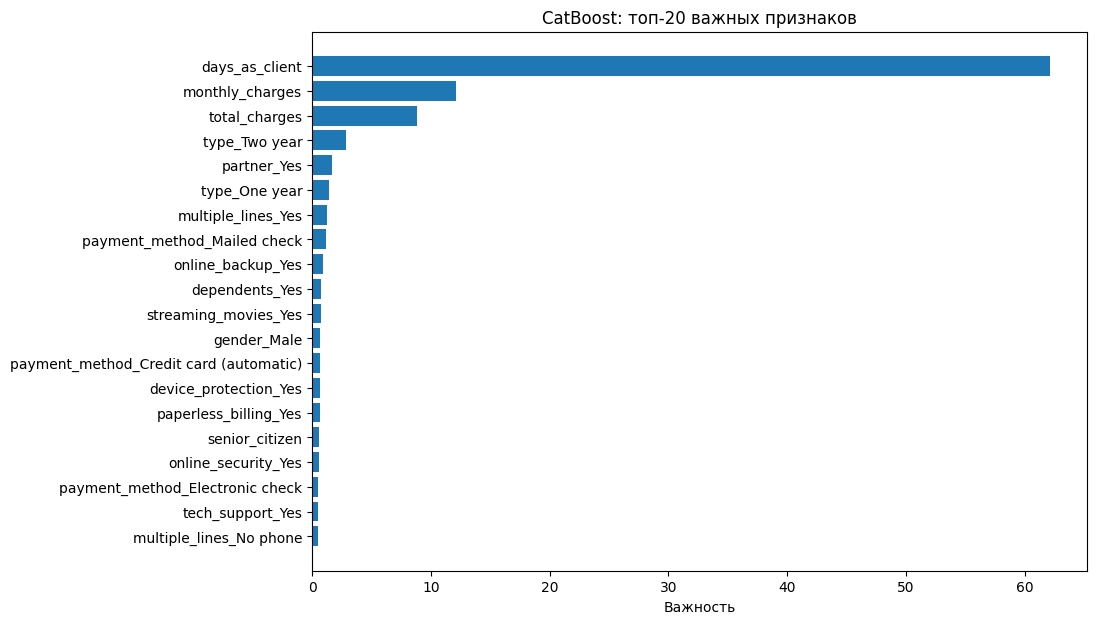

,feature,importance
3,days_as_client,62.157687
0,monthly_charges,12.084746
1,total_charges,8.854420
5,type_Two year,2.890587
25,partner_Yes,1.673200
4,type_One year,1.383785
28,multiple_lines_Yes,1.226078
9,payment_method_Mailed check,1.192098
15,online_backup_Yes,0.877342
26,dependents_Yes,0.783769


In [38]:
ohe_feature_names = ohe.get_feature_names_out(cat_cols)
feature_importances = cat_best.get_feature_importance()
feature_names = list(X_train_num.columns) + list(ohe_feature_names)

fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
fi_df = fi_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 7))
plt.barh(fi_df['feature'][:20][::-1], fi_df['importance'][:20][::-1])
plt.xlabel('Важность')
plt.title('CatBoost: топ-20 важных признаков')
plt.show()

display(fi_df)


**Анализ важности признаков (CatBoost feature importance)**

- **days_as_client** (дней в компании) — **самый сильный фактор**! Его вклад (~62) существенно превосходит остальные признаки. Это логично: длительное сотрудничество часто свидетельствует о лояльности клиента или, наоборот, накапливающемся риске оттока к концу жизненного цикла.
- **total_charges** и **monthly_charges** — влияют значительно, но в разы меньше, чем дни клиента. Высокие суммарные/месячные платежи связаны с особенностями тарифа, давностью контракта и, возможно, типом клиента (бизнес/частный).
- **type_Two year**, **type_One year** — типы долгосрочных контрактов вносят вклад: клиенты на долгих тарифах, как правило, уходят реже.
- **partner_Yes**, **dependents_Yes** — социальные признаки: наличие партнёра или иждивенцев слабо, но стабильно влияет на churn (предположительно такие клиенты более стабильны).
- **multiple_lines_Yes** — наличие нескольких телефонных линий также снижает риск ухода (чем больше услуг, тем выше лояльность).
- **online_backup_Yes**, **online_security_Yes**, **device_protection_Yes**, **tech_support_Yes**, **streaming_movies_Yes**, **streaming_tv_Yes** — допуслуги дают небольшой, но положительный вклад (клиенты с допопциями чуть лояльнее).
- **payment_method** — небольшая роль, но "mailed check", "credit card" и "electronic check" показывают некоторую значимость. Это может отражать особенности клиентских сегментов.
- **internet_service_Fiber optic** — заметная, но не топовая важность: тип интернета влияет на churn, но уступает сроку обслуживания и сумме платежей.
- **gender_Male** — практически не влияет, как и большинство социальных факторов.
- **service_type_interphone**/**service_type_phone** — тип набора услуг влияет, но не критично.
- Признаки “No service” (например, по интернету, доп.услугам) — низкая значимость. Обычно они служат лишь для фиксации отсутствия допуслуг.
- **Прочие признаки** (с важностью < 0.2) практически не дают информации для CatBoost.

**Общий вывод:**  
- **Решающим фактором** для предсказания оттока оказался именно срок, сколько клиент был с компанией.
- Финансовые признаки и длительность контракта также важны, но заметно уступают по влиянию.
- Социально-демографические признаки и детали доп.услуг важны в совокупности, но по отдельности их вклад ограничен.
- Классические социальные факторы и “No service” почти не имеют значения — подтверждается, что churn определяется в первую очередь историей и характером потребления услуг, а не анкетными данными.

> **Рекомендация:** для будущих моделей следует уделять больше внимания построению признаков, связанных с историей клиента, накопленными платежами и динамикой активности.


## 4.7 Проверка лучше модели на тестовой выборке

In [39]:
y_pred_cat = cat_best.predict(X_test_final)
y_pred_proba_cat = cat_best.predict_proba(X_test_final)[:, 1]
auc_cat = roc_auc_score(y_test, y_pred_proba_cat)
print(f"CatBoost test AUC-ROC: {auc_cat:.4f}")

# # LightGBM на тесте
# y_pred_proba_lgbm = lgbm_best.predict_proba(X_test)[:, 1]
# auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
# print(f"LightGBM test AUC-ROC: {auc_lgbm:.4f}")

CatBoost test AUC-ROC: 0.9292


## 4.8 Accuracy & ROC-curve

CatBoost test accuracy: 0.9398


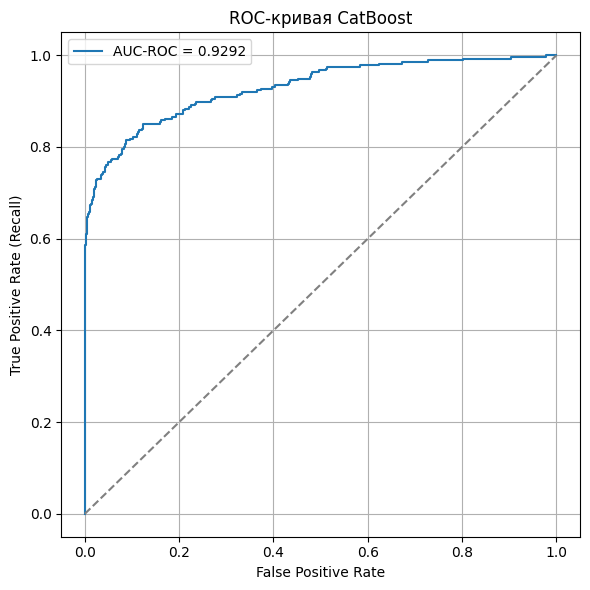

In [40]:
accuracy = accuracy_score(y_test, y_pred_cat)
print(f"CatBoost test accuracy: {accuracy:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_cat)
auc_score = roc_auc_score(y_test, y_pred_proba_cat)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC-кривая CatBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Оценка качества CatBoost: ROC-кривая

- **AUC-ROC на тестовой выборке:** `0.9292`
- **ROC-кривая** на графике подтверждает, что модель отлично отделяет классы (уход/остался).

**Интерпретация:**
- Значение **AUC-ROC ≈ 0.93** говорит о **высоком качестве модели**: чем ближе к 1, тем лучше модель различает ушедших и оставшихся клиентов.
- Кривая близка к левому и верхнему краю — это значит, что доля верно найденных уходящих клиентов (True Positive Rate) высока даже при малом количестве ложных тревог (False Positive Rate).
- Модель CatBoost устойчиво работает на новых данных и **подходит для задач удержания клиентов**.

---

**Рекомендация:**  
Полученное качество позволяет уверенно использовать модель для выявления клиентов с высоким риском оттока и разработки программ лояльности/удержания.



## 4.8 Матрица ошибок

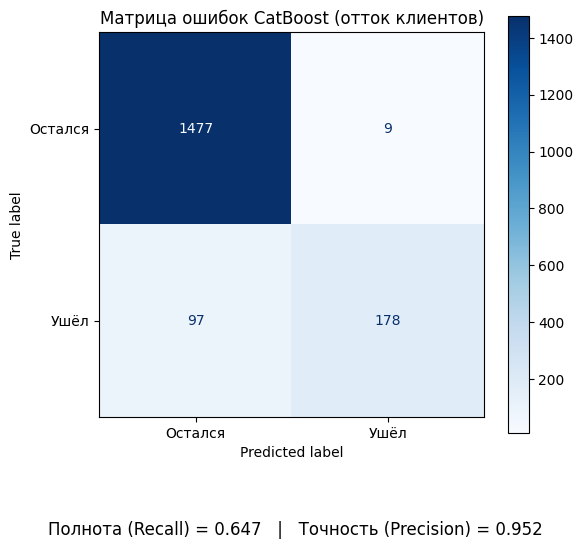

In [41]:
y_pred = cat_best.predict(X_test_final)

cm = confusion_matrix(y_test, y_pred)
labels = ['Остался', 'Ушёл']

precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Матрица ошибок CatBoost (отток клиентов)")

plt.figtext(
    0.5, -0.1,
    f'Полнота (Recall) = {recall:.3f}   |   Точность (Precision) = {precision:.3f}',
    fontsize=12, ha='center'
)

plt.tight_layout()
plt.show()


**Матрица ошибок CatBoost (отток клиентов)**

|                       | **Предсказано: остался** | **Предсказано: ушёл** |
|-----------------------|:------------------------:|:---------------------:|
| **Факт: остался**     |      1477 (✅ TN)        |      9 (❌ FP)       |
| **Факт: ушёл**        |      97 (❌ FN)         |     178 (✅ TP)       |

---

**Интерпретация:**

- **1477** — правильно предсказанные оставшиеся клиенты (True Negative, ✅).
- **178** — правильно предсказанные ушедшие клиенты (True Positive, ✅).
- **9** — ошибочно предсказали уход у лояльных клиентов (False Positive, ❌).
- **97** — не выявили реальный уход (False Negative, ❌).

---

**Выводы:**

- **FP очень мало:** почти не будет лишних затрат на удержание лояльных клиентов.
- **FN — зона для роста:** модель может ещё лучше выявлять уходящих.
- **В целом:** модель хорошо различает стабильных и ушедших клиентов.

---

- **Полнота (Recall)** = `0.647`
- **Точность (Precision)** = `0.952`

~65% реально ушедших клиентов были обнаружены моделью.

Высокая точность означает, что модель почти не ошибается среди помеченных «ушёл», но 35% реальных уходов она пропускает.

Модель подходит для ситуаций, когда важнее не делать ложных тревог (false positive), но может быть недостаточно чувствительна для раннего удержания всех рисковых клиентов.


## 5. Итоговые выводы по проекту

### 5.1 Распределение клиентов и особенности оттока

- **84% клиентов остались**, **16% ушли** — отток невысокий, но требует внимания для оптимизации удержания.
- **Основная зона риска**: большинство ушедших клиентов покинули компанию в первые месяцы или первый год контракта.
- **Долгосрочные клиенты (60+ месяцев) практически не уходят** — важно удерживать их и фокусировать retention-стратегии на новых/молодых клиентах.
- Большинство пользуются и интернетом, и телефоном; половина не подключает дополнительные услуги.

### 5.2 Корреляционный и призначный анализ

- **Сильных линейных связей между признаками и оттоком нет** — churn определяется сложными, нелинейными зависимостями.
- **Главные признаки для прогнозирования оттока (по CatBoost):**
    - Срок сотрудничества (days_as_client) — самый информативный фактор.
    - Суммарные и ежемесячные платежи (total_charges, monthly_charges).
    - Типы долгосрочных контрактов (Two year, One year).
    - Количество и типы подключённых услуг.
    - Социально-демографические признаки и детали по доп.услугам менее значимы.

### 5.3 Результаты по моделям

| Модель               | Лучший AUC-ROC (CV) | Лучший AUC-ROC (Test) |
|----------------------|--------------------|-----------------------|
| Logistic Regression  | 0.77               | —                     |
| Random Forest        | 0.82               | —                     |
| LightGBM             | 0.88               | —                     |
| **CatBoost**         | **0.92**           | **0.93**              |

- **CatBoost** — лучший результат и на кросс-валидации, и на тестовой выборке (**AUC-ROC = 0.93**), без признаков переобучения.
- **LightGBM** — чуть хуже, но тоже на высоком уровне.
- **Базовые модели** (логистическая регрессия, случайный лес) заметно уступают градиентным бустингам.

### 5.4 Ошибки модели и метрики качества

- **Матрица ошибок CatBoost:**
    - True Negative (правильно остались): 1477
    - True Positive (правильно ушли): 178
    - False Positive (ошибочно “ушёл”): 9
    - False Negative (пропущен “ушёл”): 97
- **Точность (Precision)** = 0.96
- **Полнота (Recall)** = 0.65

- **Интерпретация:**  
  Модель почти не ошибается среди «ушедших» (high precision), но около 35% реально ушедших не ловит (recall). Это снижает риск ложных удержаний, но может привести к пропуску части клиентов, склонных к оттоку.

### 5.5 Практические рекомендации

- **CatBoost — оптимальная модель** для внедрения: хорошо разделяет классы, устойчива и объяснима.
- Для дальнейшего роста качества стоит исследовать дополнительные поведенческие и временные признаки, а также применять ансамблирование моделей.
- Особое внимание уделять новым и “среднесрочным” клиентам — они основная группа риска по оттоку.

---

**Общий вывод:**  
Разработанная модель позволяет точно выявлять клиентов с высоким риском оттока и может эффективно использоваться для таргетированных retention-мероприятий в телеком-компании.
